# Greedy MSU selection

Choose MSU locations based on which improves overall utility most.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from classes.geography_processing import Geoprocessing
from classes.model import Model
from classes.scenario import Scenario

# Turn off all warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Proportion of treated patients that are LVO
prop_lvo = 0.30

# Maximum number of hospitals to select
max_hospitals = 23

## Base case

MSU provided from comprehensive stroke centres (thrombectomy centres)

In [3]:
# Set up scenario
scenario = Scenario({
    'name': 1,
    'limit_to_england' : True
})

# Process and save geographic data (only needed when hospital data changes)
geo = Geoprocessing(limit_to_england=True); geo.run()

# Set up model
model = Model(
    scenario=scenario,
    geodata=pd.read_csv('processed_data/processed_data.csv'))

# Run model
model.run()

# Get utilities
lsoa_drip_ship_utility = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility'] * (1 - prop_lvo)))

# Get the weighted average of lsoa_drip_ship_utility 
average_utility_drip_ship = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility) / np.sum(model.full_results['Admissions'])

lsoa_drip_ship_utility_shift = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

lsoa_msu_utility_shift = (
    (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

# Get the maximum of MSU and drip and ship
best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

# Get the weighted average of lsoa_drip_ship_utility shift 
average_utility_drip_ship_shift = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the average utility weighted by model.full_results['Admissions']
average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the advantage of MSU over drip and ship
advantage = average_utility_shift - average_utility_drip_ship_shift

In [4]:
untreated_utility = (average_utility_drip_ship - average_utility_drip_ship_shift)
print(f'Average untreated utility: {untreated_utility:0.3f}')
print(f'Average utility improvement for drip and ship: {average_utility_drip_ship_shift:0.3f}')
print(f'Average utility advantage for MSU over drip and ship: {advantage:0.3f}')


Average untreated utility: 0.520
Average utility improvement for drip and ship: 0.086
Average utility advantage for MSU over drip and ship: 0.022


In [5]:
# Set up scenario
scenario = Scenario({
    'name': 1,
})

# Set up geoprocessing module and load initial data (and  set Use_MSU column to zero
geo = Geoprocessing(limit_to_england = True)
geo.load_data()
geo.hospitals['Use_MSU'] = 0

# Travel processing for constant locations
geo.find_nearest_ivt_unit()
geo.find_nearest_mt_unit()
geo.find_nearest_transfer_mt_unit()

# Set up list of selected and unselected MSUs
selected_MSUs = []
used_hospitals_mask = geo.hospitals['Use_MT'] == 1
unelected_MSUs = list(geo.hospitals[used_hospitals_mask].index)

## Benefit from each hospital as a MSU base


In [6]:
geo.hospitals['Use_MSU'] = 0
hospitals = geo.hospitals.copy(deep=True)
                                   
# Loop through all MSUs
possible_msu_locations = list(geo.hospitals[used_hospitals_mask].index)
advantages = []

for msu in possible_msu_locations:
    data_copy = hospitals.copy(deep=True)
    data_copy.loc[msu, 'Use_MSU'] = 1
    geo.hospitals = data_copy.copy()
    geo.find_nearest_msu_unit()
    geo.collate_data()
    geo.save_processed_data()

    model = Model(
        scenario=scenario,
        geodata=pd.read_csv('processed_data/processed_data.csv')
    )

    model.run()

    # Get utilitites
    lsoa_msu_utility_shift = (
        (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
        (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

    lsoa_drip_ship_utility_shift = (
        (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
        (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

    # Get the maximum of MSU and drip and ship
    best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

    # Get the weighted average of lsoa_drip_ship_utility
    average_utility_drip_ship_shift = np.sum(
        model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

    # Get the average utility weighted by model.full_results['Admissions']
    average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

    # Get the advantage of MSU over drip and ship
    advantage = average_utility_shift - average_utility_drip_ship_shift

    advantages.append(advantage)


results = geo.hospitals.copy(deep=True)
results = results[used_hospitals_mask]
results['MSU advantage'] = advantages

results.to_csv('output/msu_advantages_individual.csv')

## Greedy selection of MSUs

In [7]:
hospitals = geo.hospitals.copy(deep=True)
best_advantage = 0
advantages = []

# Loop through greedy selection process
while (len(unelected_MSUs) > 0) & (len(selected_MSUs) < max_hospitals):

    # Loop through all MSUs
    for msu in unelected_MSUs:
        data_copy = hospitals.copy(deep=True)
        data_copy.loc[msu, 'Use_MSU'] = 1
        geo.hospitals = data_copy.copy()
        geo.find_nearest_msu_unit()
        geo.collate_data()
        geo.save_processed_data()

        model = Model(
            scenario=scenario,
            geodata=pd.read_csv('processed_data/processed_data.csv')
        )

        model.run()
        
            # Get utilitites
        lsoa_msu_utility_shift = (
            (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
            (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

        lsoa_drip_ship_utility_shift = (
            (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
            (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

        # Get the maximum of MSU and drip and ship
        best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

        # Get the weighted average of lsoa_drip_ship_utility
        average_utility_drip_ship_shift = np.sum(
            model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

        # Get the average utility weighted by model.full_results['Admissions']
        average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

        # Get the advantage of MSU over drip and ship
        advantage = average_utility_shift - average_utility_drip_ship_shift
        
        if advantage > best_advantage:
            best_advantage = advantage
            best_MSU = msu

    # Add the best MSU to the selected list
    selected_MSUs.append(best_MSU)
    unelected_MSUs.remove(best_MSU)
    hospitals.loc[best_MSU, 'Use_MSU'] = 1
    advantages.append(best_advantage)

    # print the best MSU and utility
    print(f'{best_MSU}, {best_advantage:0.3f}')

E11BB, 0.006
M68HD, 0.010
CV22DX, 0.012
LS13EX, 0.014
NE14LP, 0.015
BS105NB, 0.016
NG72UH, 0.017
B152TH, 0.017
SW66SX, 0.018
PL68DH, 0.018
CB20QQ, 0.019
HU32JZ, 0.019
BN25BE, 0.020
L97AL, 0.020
RM70AG, 0.020
S102JF, 0.021
PR29HT, 0.021
TS43BW, 0.021
ST46QG, 0.022
OX39DU, 0.022
NW12BU, 0.022
SW170QT, 0.022
SE59RW, 0.022


In [8]:
greedy_results = geo.hospitals.loc[selected_MSUs]
greedy_results['MSU advantage'] = advantages
greedy_results.to_csv('output/msu_advantages_greedy_csc.csv', index=False)
greedy_results

,Hospital_name,Use_IVT,Use_MT,Use_MSU,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,Admissions 21/22,...,ivt_rate,Easting,Northing,long,lat,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,MSU advantage
Postcode,,,,,,,,,,,,,,,,,,,,,
E11BB,E11BB,1,1,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,861,...,13.4,534829,181798,-0.058133,51.519018,1,1,Royal London,NaN,0.005759
M68HD,M68HD,1,1,1,England,Manchester,Lancashire & S.Cumbria SCN,Salford Royal NHS Foundation Trust,Salford Royal Hospital,1848,...,6.5,378637,399030,-2.323424,53.487545,1,1,Salford,NaN,0.009504
CV22DX,CV22DX,1,1,1,England,West Midlands SCN,University Hospitals Coventry and Warwickshire...,"University Hospital, Coventry",University Hospital Coventry,869,...,13.8,438289,280506,-1.438403,52.421211,1,1,Coventry,NaN,0.012140
LS13EX,LS13EX,1,1,1,England,Yorkshire and The Humber SCN,Leeds Teaching Hospitals NHS Trust,Leeds General Infirmary,Leeds General Infirmary,1323,...,9.4,429621,433998,-1.551744,53.801445,1,1,Leeds,NaN,0.013542
NE14LP,NE14LP,1,1,1,England,North of England SCN,Newcastle upon Tyne Hospitals NHS Foundation T...,"Royal Victoria Infirmary, Newcastle",Royal Victoria Infirmary,1096,...,12.2,424489,565063,-1.618908,54.979575,1,1,Newcastle,NaN,0.014888
BS105NB,BS105NB,1,1,1,England,South West SCN,North Bristol NHS Trust,North Bristol Hospital (Southmead),North Bristol Hospitals,775,...,7.6,358934,177759,-2.592962,51.497270,1,1,North Bristol,NaN,0.015802
NG72UH,NG72UH,1,1,1,England,East Midlands SCN,Nottingham University Hospitals NHS Trust,Queen's Medical Centre - Nottingham,Queen's Medical Centre - Nottingham,1147,...,11.9,454811,338760,-1.185800,52.943439,1,1,Nottingham,NaN,0.016589
B152TH,B152TH,1,1,1,England,West Midlands SCN,University Hospitals Birmingham NHS Foundation...,"Queen Elizabeth Hospital, Birmingham",Queen Elizabeth Hospital Edgbaston,1138,...,8.9,404278,283916,-1.938476,52.453183,1,1,Birmingham,NaN,0.017203
SW66SX,SW66SX,1,1,1,England,London SCN,Imperial College Healthcare NHS Trust,"Charing Cross Hospital, London",Charing Cross Hospital HASU,1147,...,9.9,524226,176487,-0.212736,51.473717,1,1,Charing Cross,NaN,0.017745


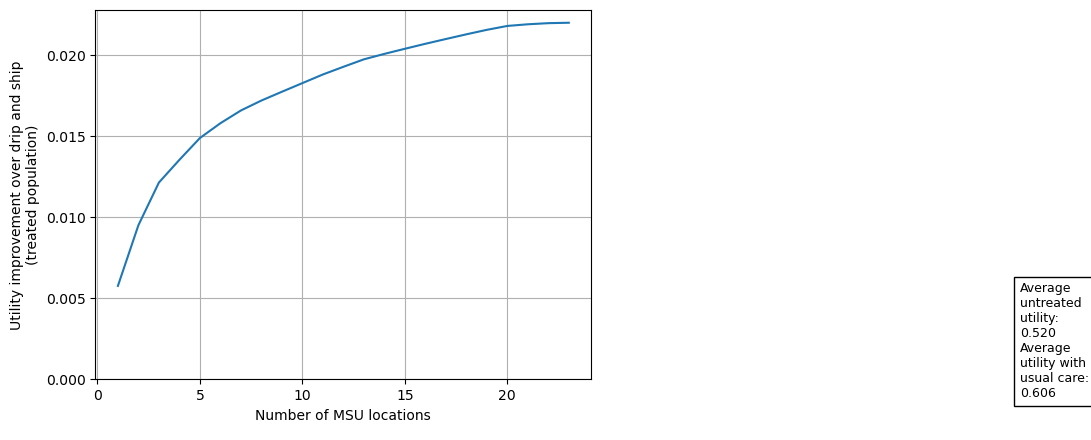

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(greedy_results)) + 1
y = greedy_results['MSU advantage']
ax.plot(x, y, '-')
ax.set_xlabel('Number of MSU locations')
ax.set_ylabel('Utility improvement over drip and ship\n(treated population)')
ax.set_ylim(0)
ax.grid()

txt = f'Average untreated utility: {untreated_utility:0.3f}' + '\n' + \
    f'Average utility with usual care: {average_utility_drip_ship:0.3f}'

plt.text(45, 0.006, txt, fontsize=9, color='black', ha='left', va='top', wrap=True, 
         bbox=dict(facecolor='white', edgecolor='black', alpha=1.0))
plt.savefig('output/msu_advantages_greedy.png', dpi=300)

plt.show()
